In [2]:
#Import Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!cp "/content/drive/My Drive/data.zip" /content/

In [6]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/all_classes.txt    
  inflating: data/test-images.npy    
  inflating: data/train-images.npy   
  inflating: data/train-labels.npy   


In [7]:
#Get Training Data
train_images_path = "data/train-images.npy" #path where data is stored
train_labels_path = "data/train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("data/all_classes.txt").readlines()]


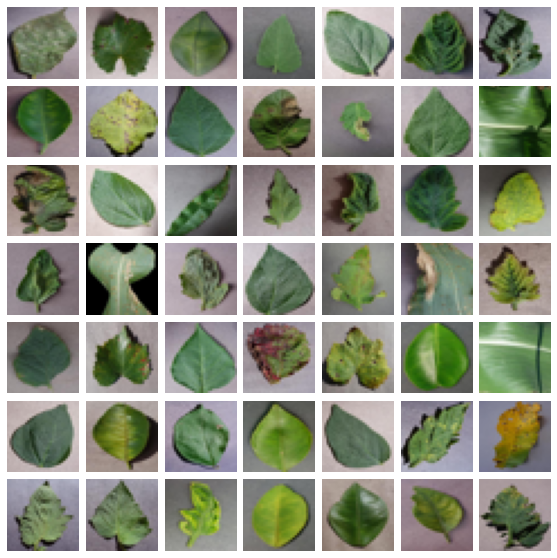

In [8]:
#Visualise Data
from mpl_toolkits.axes_grid1 import ImageGrid

def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    global class_name, train_images, train_labels
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name

"""
Render a 7x7 grid of 49 randomly sampled images
from the training set
"""
grid_shape = (7, 7)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=grid_shape,  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

data_samples = [random_data_sample() for _ in range(grid_shape[0] * grid_shape[1])]
for ax, data_sample in zip(grid, data_samples):
    image_array, class_label, class_name = data_sample
    ax.imshow(image_array)
    ax.axis('off')

plt.savefig("image-grid.png")


Class Index :  7
Class Name :  corn-maize-cercospora-leaf-spot-gray-leaf-spot
Number of images in the dataset :  410
Class Index :  4
Class Name :  blueberry-healthy
Number of images in the dataset :  1205
Class Index :  9
Class Name :  corn-maize-healthy
Number of images in the dataset :  925
Class Index :  29
Class Name :  tomato-early-blight
Number of images in the dataset :  806
Class Index :  20
Class Name :  potato-early-blight
Number of images in the dataset :  808
Class Index :  15
Class Name :  orange-haunglongbing-citrus-greening
Number of images in the dataset :  4422
Class Index :  37
Class Name :  tomato-tomato-yellow-leaf-curl-virus
Number of images in the dataset :  4238
Class Index :  5
Class Name :  cherry-including-sour-healthy
Number of images in the dataset :  666
Class Index :  28
Class Name :  tomato-bacterial-spot
Number of images in the dataset :  1738
Class Index :  16
Class Name :  peach-bacterial-spot
Number of images in the dataset :  1864
Class Index :  14


<BarContainer object of 38 artists>

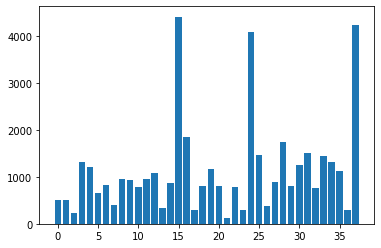

In [9]:
#Get Dataset Distribution

from collections import Counter

data_counter = Counter(train_labels)
unique_class_indices = data_counter.keys()

for _class_index in unique_class_indices:
    print("Class Index : ", _class_index)
    print("Class Name : ", class_names[_class_index])
    print("Number of images in the dataset : ", data_counter[_class_index])
    print("="*100)
    

# TODO : Add a bar plot of the distribution of the classes here
import matplotlib.pyplot as plt
data_counter = list(dict(data_counter).values())
plt.bar(unique_class_indices,data_counter)


In [10]:
#Divide Train and Test Set
X_train, X_val= train_test_split(train_images, test_size=0.2, random_state=42)
y_train, y_val= train_test_split(train_labels, test_size=0.2, random_state=42) 

In [11]:
all_classes = []
with open('/content/data/all_classes.txt') as f:
  all_classes = f.readlines()
all_classes = [i.rstrip() for i in all_classes]
all_classes

['apple-apple-scab',
 'apple-black-rot',
 'apple-cedar-apple-rust',
 'apple-healthy',
 'blueberry-healthy',
 'cherry-including-sour-healthy',
 'cherry-including-sour-powdery-mildew',
 'corn-maize-cercospora-leaf-spot-gray-leaf-spot',
 'corn-maize-common-rust',
 'corn-maize-healthy',
 'corn-maize-northern-leaf-blight',
 'grape-black-rot',
 'grape-esca-black-measles',
 'grape-healthy',
 'grape-leaf-blight-isariopsis-leaf-spot',
 'orange-haunglongbing-citrus-greening',
 'peach-bacterial-spot',
 'peach-healthy',
 'pepper-bell-bacterial-spot',
 'pepper-bell-healthy',
 'potato-early-blight',
 'potato-healthy',
 'potato-late-blight',
 'raspberry-healthy',
 'soybean-healthy',
 'squash-powdery-mildew',
 'strawberry-healthy',
 'strawberry-leaf-scorch',
 'tomato-bacterial-spot',
 'tomato-early-blight',
 'tomato-healthy',
 'tomato-late-blight',
 'tomato-leaf-mold',
 'tomato-septoria-leaf-spot',
 'tomato-spider-mites-two-spotted-spider-mite',
 'tomato-target-spot',
 'tomato-tomato-mosaic-virus',
 '

In [12]:
class MiniLeavesDataset(Dataset):

    def __init__(self,X,y,transform=None):

        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.transform:
            sample = {'X' : self.transform(self.X[idx]),'y': torch.tensor(self.y[idx].item()).type(torch.LongTensor)}
        else:
            sample = {'X': self.X[idx], 'y': torch.tensor(self.y[idx].item()).type(torch.LongTensor)}
        return sample

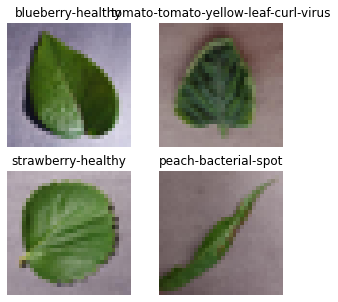

In [13]:
train_dataset = MiniLeavesDataset(X_train,y_train)

import random
samples = [train_dataset[random.randint(0,len(train_dataset))] for i in range(4)]

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs[0, 0].imshow(samples[0]['X'])
axs[0, 0].set_title(all_classes[samples[0]['y']])
axs[0, 0].axis('off')
axs[1, 0].imshow(samples[1]['X'])
axs[1, 0].set_title(all_classes[samples[1]['y']])
axs[1, 0].axis('off')
axs[0, 1].imshow(samples[2]['X'])
axs[0, 1].set_title(all_classes[samples[2]['y']])
axs[0, 1].axis('off')
axs[1, 1].imshow(samples[3]['X'])
axs[1, 1].set_title(all_classes[samples[3]['y']])
axs[1, 1].axis('off')
plt.show()


In [14]:
train_dataset = MiniLeavesDataset(X_train,y_train,torchvision.transforms.ToTensor())
test_dataset = MiniLeavesDataset(X_val,y_val,torchvision.transforms.ToTensor())

In [15]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)


In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net1()

In [18]:
#Net2 

class ResNET32(nn.Module):
  pass

  
  

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [20]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data['X'],data['y']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 3.409
[1,  4000] loss: 3.034
[1,  6000] loss: 2.728
[1,  8000] loss: 2.580
[2,  2000] loss: 2.443
[2,  4000] loss: 2.382
[2,  6000] loss: 2.323
[2,  8000] loss: 2.279
[3,  2000] loss: 2.174
[3,  4000] loss: 2.116
[3,  6000] loss: 2.093
[3,  8000] loss: 2.006
[4,  2000] loss: 1.946
[4,  4000] loss: 1.897
[4,  6000] loss: 1.860
[4,  8000] loss: 1.823
[5,  2000] loss: 1.719
[5,  4000] loss: 1.680
[5,  6000] loss: 1.636
[5,  8000] loss: 1.602
[6,  2000] loss: 1.536
[6,  4000] loss: 1.502
[6,  6000] loss: 1.494
[6,  8000] loss: 1.412
[7,  2000] loss: 1.366
[7,  4000] loss: 1.370
[7,  6000] loss: 1.337
[7,  8000] loss: 1.307
[8,  2000] loss: 1.256
[8,  4000] loss: 1.233
[8,  6000] loss: 1.224
[8,  8000] loss: 1.183
[9,  2000] loss: 1.182
[9,  4000] loss: 1.143
[9,  6000] loss: 1.105
[9,  8000] loss: 1.088
[10,  2000] loss: 1.058
[10,  4000] loss: 1.082
[10,  6000] loss: 1.040
[10,  8000] loss: 1.042
Finished Training


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data['X'],data['y']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %
